# Subject

**a. Task**

In this project, you will work on a churn prediction. You will need to predict which customers are going to stop being customers of the bank. You will need to use a multilayer perceptron for your final prediction.
- Baseline. Naive classifier where you use the most popular class for predictions.
- Random forest. Solve the task with the random forest as another baseline solution,
use grid search to find optimal hyperparameters.
- Scikit-learn. Solve the task using MLPClassifier.
- Keras. Solve the task using Keras from the TensorFlow library.
- TensorFlow. Solve the task using the TensorFlow library.
- NumPy. Implement the best architecture that you achieved earlier but with NumPy using matrix calculations. You need to train the model and use it for inference (predictions).

**b. Dataset**

You will work with the dataset of one of the Russian banks. It contains different data about their customers: financial information, their age, services that they used, and the target – whether they left the bank in the next three months. There are two files: train and test. You will use the train data to fit the models and make predictions for the test dataset.

**c. Implementation**

You can work in Jupyter Notebooks. The notebooks should be well-formatted. You need to make a split on the train and test (20%) datasets with stratification. You may apply any preprocessing for the data: working with anomalies, missing values, feature generation, and selection. Use a grid search to find the best hyperparameters.

In the last part of the task when you will implement your neural network, please, use OOP principles.

At the end of your notebook(s), you need to create a table with the results of your research where you should display the name of the library, algorithms, hyperparameters, and the score (accuracy and AUC) of the models you used (including baseline solutions). Try to use dropout for model regularization.

**d. Submission**

After you finish working with the models, you need to save the final predictions in the CSV-file with only two fields: “ID” and “TARGET”. The order of IDs should be the same as in the test dataset you were given. The values of “TARGET” can be either the class or the probability.

You need to achieve AUC at least equal 0.8183 on the test dataset with a neural network solution. It will be calculated with an automated checker.

Your repository should contain one or several notebooks with your solutions as well as the prediction file.

**Bonus part**

- Try to achieve a better AUC on the test dataset with a neural network solution – 0.83.
- Try to achieve an even better AUC on the test dataset with a neural network solution – 0.85.

# Colab setting

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-a5145eea-9cd2-58eb-034b-638825cfe4ca)


In [ ]:
# !pip install scikit-learn --upgrade

# Imports

In [485]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

pd.set_option('max_columns', 400)
pd.set_option('max_rows', 400)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print('tensorflow version: ', tf.__version__)

tensorflow version:  2.7.0


# Variables

In [507]:
# PATH = '/content/drive/MyDrive/Colab Notebooks/21/churn/'
PATH = ''

# Switch for models
models = {'model_1': 1, # Baseline
          'model_2': 1, # Random forest
          'model_3': 1, # MLPClassifier
          'model_4': 1, # Keras
          'model_5': 1, # TensorFlow
          'model_6': 1  # Numpy
          }
results = pd.DataFrame(columns=['model', 'library', 'algorithms', 'hyperparameters', 'score'])

# Functions

In [487]:
class Softmax:
    def forward(self, x):
        x = x - np.max(x)
        self.p = np.exp(x) / np.sum(np.exp(x))
        return self.p

    def backward(self, dz):
        jacobian = np.diag(dz)
        for i in range(len(jacobian)):
            for j in range(len(jacobian)):
                if i == j:
                    jacobian[i][j] = self.p[i] * (1 - self.p[j])
                else:
                    jacobian[i][j] = -self.p[i] * self.p[j]
        return np.matmul(dz, jacobian)


class ReLu:
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, dz):
        dz[self.x <= 0] = 0
        dz[self.x > 0] = 1
        return dz


class Sigmoid:
    def forward(self, x):
        self.p = 1/(1 + np.exp(-x))
        return self.p

    def backward(self, dz):
        s = 1/(1 + np.exp(-dz))
        dz = s * (1 - s)
        return dz


class Dense:
    def __init__(self, in_size, out_size, reg_lambda=0.0):
        self.W = np.random.normal(
            scale=1, size=(out_size, in_size)) * np.sqrt(2 / (in_size + out_size))
        self.b = np.zeros(out_size)
        self.reg_lambda = reg_lambda
        self.final_dW = 0
        self.final_db = 0

    def forward(self, x):
        self.x = x
        if np.array(x).shape[0] != self.W.shape[1]:
            print('X is not the same dimention as in_size')
        return (np.dot(self.W, self.x) + self.b)

    # честно верим, что эта функция работает правильно
    def get_reg_loss(self):
        return 0.5 * self.reg_lambda * (np.linalg.norm(self.W, ord='fro')**2)

    def backward(self,
                 dz,
                 learning_rate=0.001,
                 mini_batch=False,
                 update=True,
                 len_mini_batch=None):
        self.dW = np.outer(dz, self.x)
        self.db = dz
        self.dx = np.dot(dz, self.W)

        if (self.reg_lambda != 0):
            self.dW += self.reg_lambda * self.W

        if mini_batch == True:
            self.final_dW += self.dW
            self.final_db += self.db

        if update == True:
            if mini_batch == True:
                self.W = self.W - learning_rate * self.final_dW / len_mini_batch
                self.b = self.b - learning_rate * self.final_db / len_mini_batch
                self.final_dW = 0
                self.final_db = 0
            else:
                self.W = self.W - learning_rate * self.dW
                self.b = self.b - learning_rate * self.db

        return self.dx


class Dropout:
    def __init__(self, p=0.5):
        self.p = p

    def forward(self, x, train=True):
        if not train:
            self.mask = np.ones(*x.shape)
            return x
        self.mask = (np.random.rand(*x.shape) > self.p) / (1.0 - self.p)
        return x * self.mask

    def backward(self, dz, lr=0.001):
        return dz * self.mask


class CrossEntropy:
    def forward(self, y_true, y_hat):
        self.y_hat = y_hat
        self.y_true = y_true
        self.loss = -np.sum(self.y_true * np.log(y_hat))
        return self.loss

    def backward(self):
        dz = -self.y_true / self.y_hat
        return dz


class ChurnNetMiniBatch:
    def __init__(self):
        self.d1_layer = Dense(102, 64)
        self.a1_layer = ReLu()
        self.drop1_layer = Dropout(0.2)

        self.d2_layer = Dense(64, 32)
        self.a2_layer = ReLu()
        self.drop2_layer = Dropout(0.25)

        self.d3_layer = Dense(32, 1)
        self.a3_layer = Sigmoid()

    def forward(self, x, train=True):
        net = self.d1_layer.forward(x)
        net = self.a1_layer.forward(net)
        net = self.drop1_layer.forward(net, train)

        net = self.d2_layer.forward(net)
        net = self.a2_layer.forward(net)
        net = self.drop2_layer.forward(net, train)

        net = self.d3_layer.forward(net)
        net = self.a3_layer.forward(net)

        return (net)

    def backward(self,
                 dz,
                 learning_rate=0.01,
                 mini_batch=True,
                 update=False,
                 len_mini_batch=None):

        dz = self.a3_layer.backward(dz)
        dz = self.d3_layer.backward(
            dz,
            learning_rate=learning_rate,
            mini_batch=mini_batch,
            update=update,
            len_mini_batch=len_mini_batch)

        dz = self.drop2_layer.backward(dz)
        dz = self.a2_layer.backward(dz)
        dz = self.d2_layer.backward(
            dz,
            learning_rate=learning_rate,
            mini_batch=mini_batch,
            update=update,
            len_mini_batch=len_mini_batch)

        dz = self.drop1_layer.backward(dz)
        dz = self.a1_layer.backward(dz)
        dz = self.d1_layer.backward(
            dz,
            learning_rate=learning_rate,
            mini_batch=mini_batch,
            update=update,
            len_mini_batch=len_mini_batch)

        return dz


def compute_acc(X_test, Y_test, net):
    '''Not one-hot encoded format'''
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if (y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

# Data

In [488]:
df_test = pd.read_csv(PATH+'data/bank_data_test.csv')
df_test.head()

,ID,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,PRC_ACCEPTS_A_EMAIL_LINK,APP_REGISTR_RGN_CODE,PRC_ACCEPTS_A_POS,PRC_ACCEPTS_A_TK,TURNOVER_DYNAMIC_IL_1M,CNT_TRAN_AUT_TENDENCY1M,SUM_TRAN_AUT_TENDENCY1M,AMOUNT_RUB_SUP_PRC,PRC_ACCEPTS_A_AMOBILE,SUM_TRAN_AUT_TENDENCY3M,CLNT_TRUST_RELATION,PRC_ACCEPTS_TK,PRC_ACCEPTS_A_MTP,REST_DYNAMIC_FDEP_1M,CNT_TRAN_AUT_TENDENCY3M,CNT_ACCEPTS_TK,APP_MARITAL_STATUS,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,CNT_TRAN_MED_TENDENCY1M,APP_KIND_OF_PROP_HABITATION,CLNT_JOB_POSITION_TYPE,AMOUNT_RUB_NAS_PRC,CLNT_JOB_POSITION,APP_DRIVING_LICENSE,TRANS_COUNT_SUP_PRC,APP_EDUCATION,CNT_TRAN_CLO_TENDENCY1M,SUM_TRAN_MED_TENDENCY1M,PRC_ACCEPTS_A_ATM,PRC_ACCEPTS_MTP,TRANS_COUNT_NAS_PRC,APP_TRAVEL_PASS,CNT_ACCEPTS_MTP,CR_PROD_CNT_TOVR,APP_CAR,CR_PROD_CNT_PIL,SUM_TRAN_CLO_TENDENCY1M,APP_POSITION_TYPE,TURNOVER_CC,TRANS_COUNT_ATM_PRC,AMOUNT_RUB_ATM_PRC,TURNOVER_PAYM,AGE,CNT_TRAN_MED_TENDENCY3M,CR_PROD_CNT_CC,SUM_TRAN_MED_TENDENCY3M,REST_DYNAMIC_FDEP_3M,REST_DYNAMIC_IL_1M,APP_EMP_TYPE,SUM_TRAN_CLO_TENDENCY3M,LDEAL_TENOR_MAX,LDEAL_YQZ_CHRG,CR_PROD_CNT_CCFP,DEAL_YQZ_IR_MAX,LDEAL_YQZ_COM,DEAL_YQZ_IR_MIN,CNT_TRAN_CLO_TENDENCY3M,REST_DYNAMIC_CUR_1M,REST_AVG_PAYM,LDEAL_TENOR_MIN,LDEAL_AMT_MONTH,APP_COMP_TYPE,LDEAL_GRACE_DAYS_PCT_MED,REST_DYNAMIC_CUR_3M,CNT_TRAN_SUP_TENDENCY3M,TURNOVER_DYNAMIC_CUR_1M,REST_DYNAMIC_PAYM_3M,SUM_TRAN_SUP_TENDENCY3M,REST_DYNAMIC_IL_3M,CNT_TRAN_ATM_TENDENCY3M,CNT_TRAN_ATM_TENDENCY1M,TURNOVER_DYNAMIC_IL_3M,SUM_TRAN_ATM_TENDENCY3M,DEAL_GRACE_DAYS_ACC_S1X1,AVG_PCT_MONTH_TO_PCLOSE,DEAL_YWZ_IR_MIN,SUM_TRAN_SUP_TENDENCY1M,DEAL_YWZ_IR_MAX,SUM_TRAN_ATM_TENDENCY1M,REST_DYNAMIC_PAYM_1M,CNT_TRAN_SUP_TENDENCY1M,DEAL_GRACE_DAYS_ACC_AVG,TURNOVER_DYNAMIC_CUR_3M,PACK,MAX_PCLOSE_DATE,LDEAL_YQZ_PC,CLNT_SETUP_TENOR,DEAL_GRACE_DAYS_ACC_MAX,TURNOVER_DYNAMIC_PAYM_3M,LDEAL_DELINQ_PER_MAXYQZ,TURNOVER_DYNAMIC_PAYM_1M,CLNT_SALARY_VALUE,TRANS_AMOUNT_TENDENCY3M,MED_DEBT_PRC_YQZ,TRANS_CNT_TENDENCY3M,LDEAL_USED_AMT_AVG_YQZ,REST_DYNAMIC_CC_1M,LDEAL_USED_AMT_AVG_YWZ,TURNOVER_DYNAMIC_CC_1M,AVG_PCT_DEBT_TO_DEAL_AMT,LDEAL_ACT_DAYS_ACC_PCT_AVG,REST_DYNAMIC_CC_3M,MED_DEBT_PRC_YWZ,LDEAL_ACT_DAYS_PCT_TR3,LDEAL_ACT_DAYS_PCT_AAVG,LDEAL_DELINQ_PER_MAXYWZ,TURNOVER_DYNAMIC_CC_3M,LDEAL_ACT_DAYS_PCT_TR,LDEAL_ACT_DAYS_PCT_TR4,LDEAL_ACT_DAYS_PCT_CURR,TARGET
0,400980,0,0.000,NaN,NaN,NaN,NaN,0.000,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,0.000,0,0.000,NaN,NaN,NaN,0.000,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,0,NaN,0,NaN,NaN,0.000,1.000,1.000,24039.833,336,NaN,0,NaN,0.000,0.000,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.000,4040.117,NaN,NaN,NaN,0.000,0.000,NaN,0.000,0.219,NaN,0.000,0.429,0.143,0.000,0.221,NaN,NaN,NaN,NaN,NaN,0.139,0.133,NaN,NaN,0.000,105,NaN,NaN,2.488,NaN,0.202,NaN,0.069,NaN,0.221,NaN,0.429,NaN,0.000,NaN,0.000,NaN,NaN,0.000,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN
1,525062,0,0.059,0.000,NaN,0.000,0.000,0.000,NaN,NaN,0.000,0.000,NaN,NaN,0.000,0.000,0.000,NaN,0.000,NaN,0.000,0,79727.888,NaN,NaN,NaN,0.003,NaN,NaN,0.020,NaN,0.375,NaN,0.000,0.000,0.224,NaN,0.000,1,NaN,0,0.519,NaN,0.000,0.041,0.014,0.000,612,NaN,0,NaN,0.000,0.000,NaN,0.917,NaN,NaN,0,NaN,NaN,NaN,0.875,0.245,0.000,NaN,NaN,NaN,0.000,0.468,1.000,0.195,0.000,1.000,0.000,0.500,NaN,0.000,0.592,0.000,NaN,20.000,NaN,20.000,NaN,0.000,NaN,0.000,0.312,102,NaN,NaN,3.007,0.000,0.000,NaN,0.000,NaN,0.302,NaN,0.653,NaN,0.000,1.000,0.000,NaN,0.500,0.000,1.000,0.500,0.500,0.000,0.000,0.500,0.500,0.500,NaN
2,280316,0,0.070,0.000,NaN,0.000,0.000,0.000,NaN,NaN,0.078,0.000,NaN,NaN,0.000,0.000,0.000,NaN,0.000,NaN,0.000,0,49743.852,0.143,NaN,NaN,0.010,ПРЕПОДАВАТЕЛЬ,NaN,0.157,NaN,0.111,0.185,0.000,0.000,0.014,NaN,0.000,0,NaN,0,0.030,NaN,0.000,0.314,0.740,0.000,396,0.714,0,0.769,0.000,0.000,NaN,0.656,NaN,NaN,0,NaN,NaN,NaN,0.889,0.083,0.000,NaN,NaN,NaN,0.000,0.374,0.818,0.123,0.000,0.884,0.000,0.727,0.227,0.000,0.646,NaN,NaN,NaN,0.146,NaN,0.108,0.000,0.273,NaN,0.654,102,NaN,NaN,2.045,NaN,0.000,NaN,0.000,NaN,0.657,NaN,0.700,NaN,0.000,NaN,0.000,NaN,NaN,0.000,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,Na

In [489]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88798 entries, 0 to 88797
Columns: 116 entries, ID to TARGET
dtypes: float64(95), int64(8), object(13)
memory usage: 78.6+ MB


In [490]:
df_test.describe()

,ID,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,PRC_ACCEPTS_A_EMAIL_LINK,APP_REGISTR_RGN_CODE,PRC_ACCEPTS_A_POS,PRC_ACCEPTS_A_TK,TURNOVER_DYNAMIC_IL_1M,CNT_TRAN_AUT_TENDENCY1M,SUM_TRAN_AUT_TENDENCY1M,AMOUNT_RUB_SUP_PRC,PRC_ACCEPTS_A_AMOBILE,SUM_TRAN_AUT_TENDENCY3M,PRC_ACCEPTS_TK,PRC_ACCEPTS_A_MTP,REST_DYNAMIC_FDEP_1M,CNT_TRAN_AUT_TENDENCY3M,CNT_ACCEPTS_TK,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,CNT_TRAN_MED_TENDENCY1M,AMOUNT_RUB_NAS_PRC,TRANS_COUNT_SUP_PRC,CNT_TRAN_CLO_TENDENCY1M,SUM_TRAN_MED_TENDENCY1M,PRC_ACCEPTS_A_ATM,PRC_ACCEPTS_MTP,TRANS_COUNT_NAS_PRC,CNT_ACCEPTS_MTP,CR_PROD_CNT_TOVR,CR_PROD_CNT_PIL,SUM_TRAN_CLO_TENDENCY1M,TURNOVER_CC,TRANS_COUNT_ATM_PRC,AMOUNT_RUB_ATM_PRC,TURNOVER_PAYM,AGE,CNT_TRAN_MED_TENDENCY3M,CR_PROD_CNT_CC,SUM_TRAN_MED_TENDENCY3M,REST_DYNAMIC_FDEP_3M,REST_DYNAMIC_IL_1M,SUM_TRAN_CLO_TENDENCY3M,LDEAL_TENOR_MAX,LDEAL_YQZ_CHRG,CR_PROD_CNT_CCFP,DEAL_YQZ_IR_MAX,LDEAL_YQZ_COM,DEAL_YQZ_IR_MIN,CNT_TRAN_CLO_TENDENCY3M,REST_DYNAMIC_CUR_1M,REST_AVG_PAYM,LDEAL_TENOR_MIN,LDEAL_AMT_MONTH,LDEAL_GRACE_DAYS_PCT_MED,REST_DYNAMIC_CUR_3M,CNT_TRAN_SUP_TENDENCY3M,TURNOVER_DYNAMIC_CUR_1M,REST_DYNAMIC_PAYM_3M,SUM_TRAN_SUP_TENDENCY3M,REST_DYNAMIC_IL_3M,CNT_TRAN_ATM_TENDENCY3M,CNT_TRAN_ATM_TENDENCY1M,TURNOVER_DYNAMIC_IL_3M,SUM_TRAN_ATM_TENDENCY3M,DEAL_GRACE_DAYS_ACC_S1X1,AVG_PCT_MONTH_TO_PCLOSE,DEAL_YWZ_IR_MIN,SUM_TRAN_SUP_TENDENCY1M,DEAL_YWZ_IR_MAX,SUM_TRAN_ATM_TENDENCY1M,REST_DYNAMIC_PAYM_1M,CNT_TRAN_SUP_TENDENCY1M,DEAL_GRACE_DAYS_ACC_AVG,TURNOVER_DYNAMIC_CUR_3M,MAX_PCLOSE_DATE,LDEAL_YQZ_PC,CLNT_SETUP_TENOR,DEAL_GRACE_DAYS_ACC_MAX,TURNOVER_DYNAMIC_PAYM_3M,LDEAL_DELINQ_PER_MAXYQZ,TURNOVER_DYNAMIC_PAYM_1M,CLNT_SALARY_VALUE,TRANS_AMOUNT_TENDENCY3M,MED_DEBT_PRC_YQZ,TRANS_CNT_TENDENCY3M,LDEAL_USED_AMT_AVG_YQZ,REST_DYNAMIC_CC_1M,LDEAL_USED_AMT_AVG_YWZ,TURNOVER_DYNAMIC_CC_1M,AVG_PCT_DEBT_TO_DEAL_AMT,LDEAL_ACT_DAYS_ACC_PCT_AVG,REST_DYNAMIC_CC_3M,MED_DEBT_PRC_YWZ,LDEAL_ACT_DAYS_PCT_TR3,LDEAL_ACT_DAYS_PCT_AAVG,LDEAL_DELINQ_PER_MAXYWZ,TURNOVER_DYNAMIC_CC_3M,LDEAL_ACT_DAYS_PCT_TR,LDEAL_ACT_DAYS_PCT_TR4,LDEAL_ACT_DAYS_PCT_CURR,TARGET
count,88798.000,88798.000,79198.000,38520.000,15332.000,38520.000,38520.000,88798.000,19282.000,19282.000,79198.000,38520.000,27584.000,38520.000,38520.000,88798.000,27584.000,38520.000,88798.000,88798.000,88798.000,17240.000,79198.000,79198.000,16500.000,17240.000,38520.000,38520.000,79198.000,38520.000,88798.000,88798.000,16500.000,88798.000,79198.000,79198.000,88798.000,88798.000,28901.000,88798.000,28901.000,88798.000,88798.000,28456.000,2108.000,333.000,88798.000,2108.000,323.000,2108.000,28456.000,88798.000,88798.000,2108.000,504.000,88798.000,88798.000,49663.000,88798.000,88798.000,49663.000,88798.000,63824.000,51451.000,88798.000,63824.000,17445.000,426.000,23817.000,38927.000,23817.000,51451.000,88798.000,38927.000,17222.000,88798.000,504.000,751.000,88798.000,17222.000,88798.000,2108.000,88798.000,173.000,75844.000,2108.000,75844.000,2108.000,88798.000,23817.000,88798.000,504.000,23281.000,88798.000,23817.000,23281.000,24452.000,23817.000,88798.000,23281.000,23281.000,23281.000,0.000
mean,368993.800,0.106,0.045,0.000,51.234,0.000,0.000,0.001,0.418,0.415,0.086,0.000,0.690,0.000,0.000,0.001,0.692,0.000,0.065,0.032,66097.052,0.451,0.024,0.192,0.480,0.444,0.000,0.000,0.051,0.000,0.309,0.057,0.473,492.378,0.371,0.598,14390.485,457.822,0.703,0.071,0.697,0.004,0.002,0.701,22.257,0.004,0.005,26.422,0.075,25.755,0.703,0.213,7145.520,15.766,206577.214,0.002,0.500,0.645,0.205,0.077,0.630,0.006,0.631,0.328,0.004,0.620,0.028,-2.314,37.212,0.332,39.489,0.322,0.028,0.345,0.024,0.485,-19.883,0.028,4.373,0.029,0.072,0.202,0.025,35077.985,0.583,0.919,0.599,0.442,0.002,0.901,0.001,0.383,0.051,0.007,0.053,0.026,0.051,0.010,0.004,0.014,0.014,0.014,NaN
std,128247.549,0.434,0.111,0.000,21.545,0.000,0.000,0.030,0.316,0.337,0.142,0.000,0.301,0.000,0.000,0.015,0.277,0.000,0.206,0.184,173380.218,0.327,0.089,0.197,0.330,0.364,0.000,0.000,0.117,0.000,0.589,0.295,0.361,12593.536,0.344,0.365,89822.409,136.327,0.283,0.292,0.323,

In [491]:
df_test.isnull().sum()

ID                                 0
CR_PROD_CNT_IL                     0
AMOUNT_RUB_CLO_PRC              9600
PRC_ACCEPTS_A_EMAIL_LINK       50278
APP_REGISTR_RGN_CODE           73466
PRC_ACCEPTS_A_POS              50278
PRC_ACCEPTS_A_TK               50278
TURNOVER_DYNAMIC_IL_1M             0
CNT_TRAN_AUT_TENDENCY1M        69516
SUM_TRAN_AUT_TENDENCY1M        69516
AMOUNT_RUB_SUP_PRC              9600
PRC_ACCEPTS_A_AMOBILE          50278
SUM_TRAN_AUT_TENDENCY3M        61214
CLNT_TRUST_RELATION            71301
PRC_ACCEPTS_TK                 50278
PRC_ACCEPTS_A_MTP              50278
REST_DYNAMIC_FDEP_1M               0
CNT_TRAN_AUT_TENDENCY3M        61214
CNT_ACCEPTS_TK                 50278
APP_MARITAL_STATUS             71590
REST_DYNAMIC_SAVE_3M               0
CR_PROD_CNT_VCU                    0
REST_AVG_CUR                       0
CNT_TRAN_MED_TENDENCY1M        71558
APP_KIND_OF_PROP_HABITATION    73816
CLNT_JOB_POSITION_TYPE         77496
AMOUNT_RUB_NAS_PRC              9600
C

In [492]:
df = pd.read_csv(PATH+'data/bank_data_train.csv')
df.head()

,ID,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,PRC_ACCEPTS_A_EMAIL_LINK,APP_REGISTR_RGN_CODE,PRC_ACCEPTS_A_POS,PRC_ACCEPTS_A_TK,TURNOVER_DYNAMIC_IL_1M,CNT_TRAN_AUT_TENDENCY1M,SUM_TRAN_AUT_TENDENCY1M,AMOUNT_RUB_SUP_PRC,PRC_ACCEPTS_A_AMOBILE,SUM_TRAN_AUT_TENDENCY3M,CLNT_TRUST_RELATION,PRC_ACCEPTS_TK,PRC_ACCEPTS_A_MTP,REST_DYNAMIC_FDEP_1M,CNT_TRAN_AUT_TENDENCY3M,CNT_ACCEPTS_TK,APP_MARITAL_STATUS,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,CNT_TRAN_MED_TENDENCY1M,APP_KIND_OF_PROP_HABITATION,CLNT_JOB_POSITION_TYPE,AMOUNT_RUB_NAS_PRC,CLNT_JOB_POSITION,APP_DRIVING_LICENSE,TRANS_COUNT_SUP_PRC,APP_EDUCATION,CNT_TRAN_CLO_TENDENCY1M,SUM_TRAN_MED_TENDENCY1M,PRC_ACCEPTS_A_ATM,PRC_ACCEPTS_MTP,TRANS_COUNT_NAS_PRC,APP_TRAVEL_PASS,CNT_ACCEPTS_MTP,CR_PROD_CNT_TOVR,APP_CAR,CR_PROD_CNT_PIL,SUM_TRAN_CLO_TENDENCY1M,APP_POSITION_TYPE,TURNOVER_CC,TRANS_COUNT_ATM_PRC,AMOUNT_RUB_ATM_PRC,TURNOVER_PAYM,AGE,CNT_TRAN_MED_TENDENCY3M,CR_PROD_CNT_CC,SUM_TRAN_MED_TENDENCY3M,REST_DYNAMIC_FDEP_3M,REST_DYNAMIC_IL_1M,APP_EMP_TYPE,SUM_TRAN_CLO_TENDENCY3M,LDEAL_TENOR_MAX,LDEAL_YQZ_CHRG,CR_PROD_CNT_CCFP,DEAL_YQZ_IR_MAX,LDEAL_YQZ_COM,DEAL_YQZ_IR_MIN,CNT_TRAN_CLO_TENDENCY3M,REST_DYNAMIC_CUR_1M,REST_AVG_PAYM,LDEAL_TENOR_MIN,LDEAL_AMT_MONTH,APP_COMP_TYPE,LDEAL_GRACE_DAYS_PCT_MED,REST_DYNAMIC_CUR_3M,CNT_TRAN_SUP_TENDENCY3M,TURNOVER_DYNAMIC_CUR_1M,REST_DYNAMIC_PAYM_3M,SUM_TRAN_SUP_TENDENCY3M,REST_DYNAMIC_IL_3M,CNT_TRAN_ATM_TENDENCY3M,CNT_TRAN_ATM_TENDENCY1M,TURNOVER_DYNAMIC_IL_3M,SUM_TRAN_ATM_TENDENCY3M,DEAL_GRACE_DAYS_ACC_S1X1,AVG_PCT_MONTH_TO_PCLOSE,DEAL_YWZ_IR_MIN,SUM_TRAN_SUP_TENDENCY1M,DEAL_YWZ_IR_MAX,SUM_TRAN_ATM_TENDENCY1M,REST_DYNAMIC_PAYM_1M,CNT_TRAN_SUP_TENDENCY1M,DEAL_GRACE_DAYS_ACC_AVG,TURNOVER_DYNAMIC_CUR_3M,PACK,MAX_PCLOSE_DATE,LDEAL_YQZ_PC,CLNT_SETUP_TENOR,DEAL_GRACE_DAYS_ACC_MAX,TURNOVER_DYNAMIC_PAYM_3M,LDEAL_DELINQ_PER_MAXYQZ,TURNOVER_DYNAMIC_PAYM_1M,CLNT_SALARY_VALUE,TRANS_AMOUNT_TENDENCY3M,MED_DEBT_PRC_YQZ,TRANS_CNT_TENDENCY3M,LDEAL_USED_AMT_AVG_YQZ,REST_DYNAMIC_CC_1M,LDEAL_USED_AMT_AVG_YWZ,TURNOVER_DYNAMIC_CC_1M,AVG_PCT_DEBT_TO_DEAL_AMT,LDEAL_ACT_DAYS_ACC_PCT_AVG,REST_DYNAMIC_CC_3M,MED_DEBT_PRC_YWZ,LDEAL_ACT_DAYS_PCT_TR3,LDEAL_ACT_DAYS_PCT_AAVG,LDEAL_DELINQ_PER_MAXYWZ,TURNOVER_DYNAMIC_CC_3M,LDEAL_ACT_DAYS_PCT_TR,LDEAL_ACT_DAYS_PCT_TR4,LDEAL_ACT_DAYS_PCT_CURR,TARGET
0,146841,0,0.000,NaN,NaN,NaN,NaN,0.000,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,0.542,0,156067.340,NaN,NaN,NaN,0.000,начальник отдела,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,0,NaN,0,NaN,NaN,0.000,1.000,1.000,0.000,660,NaN,0,NaN,0.000,0.000,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.135,0.000,NaN,NaN,NaN,0.000,0.474,NaN,0.132,0.000,NaN,0.000,0.407,0.102,0.000,0.483,NaN,NaN,NaN,NaN,NaN,0.135,0.000,NaN,NaN,0.442,K01,NaN,NaN,1.593,NaN,0.000,NaN,0.000,NaN,0.483,NaN,0.407,NaN,0.000,NaN,0.000,NaN,NaN,0.000,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,0
1,146842,0,0.041,NaN,NaN,NaN,NaN,0.000,0.167,0.186,0.245,NaN,0.671,NaN,NaN,NaN,0.000,0.667,NaN,NaN,0.000,0,4278.846,NaN,NaN,NaN,0.000,NaN,NaN,0.455,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,0,NaN,0,NaN,NaN,0.000,0.109,0.411,0.000,552,NaN,0,NaN,0.000,0.000,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.239,0.000,NaN,NaN,NaN,0.000,0.384,0.600,0.102,0.000,0.511,0.000,0.333,0.167,0.000,0.200,NaN,NaN,NaN,0.310,NaN,0.133,0.000,0.240,NaN,0.516,102,NaN,NaN,1.588,NaN,0.000,NaN,0.000,NaN,0.394,NaN,0.545,NaN,0.000,NaN,0.000,NaN,NaN,0.000,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,0
2,146843,0,0.007,0.000,NaN,0.000,0.000,0.000,NaN,NaN,0.000,0.000,NaN,NaN,0.000,0.000,0.000,NaN,0.000,NaN,0.000,0,112837.063,NaN,NaN,NaN,0.000,ГЕНЕРАЛЬНЫЙ ДИРЕКТОР,NaN,0.000,NaN,NaN,NaN,0.000,0.000,0.000,NaN,0.000,0,NaN,0,NaN,NaN,0.000,0.811,0.925,0.000,420,NaN,0,NaN,0.000,0.000,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.084,0.000,NaN,NaN,NaN,0.000,0.336,NaN,0.121,0.000,NaN,0.000,0.367,0.133,0.000,0.432,NaN,NaN,NaN,NaN,NaN,0.063,0.000,NaN,NaN,0.523,102,NaN,NaN,1.588,NaN,0.000,NaN,0.000,NaN,0.399,NaN,0.297,NaN,0.000,NaN,0.000,NaN,NaN,0.000,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,0
3,146844,0,0.000,NaN,NaN,NaN,NaN,0.000,NaN,NaN,0.000

In [493]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355190 entries, 0 to 355189
Columns: 116 entries, ID to TARGET
dtypes: float64(94), int64(9), object(13)
memory usage: 314.3+ MB


In [494]:
df.describe()

,ID,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,PRC_ACCEPTS_A_EMAIL_LINK,APP_REGISTR_RGN_CODE,PRC_ACCEPTS_A_POS,PRC_ACCEPTS_A_TK,TURNOVER_DYNAMIC_IL_1M,CNT_TRAN_AUT_TENDENCY1M,SUM_TRAN_AUT_TENDENCY1M,AMOUNT_RUB_SUP_PRC,PRC_ACCEPTS_A_AMOBILE,SUM_TRAN_AUT_TENDENCY3M,PRC_ACCEPTS_TK,PRC_ACCEPTS_A_MTP,REST_DYNAMIC_FDEP_1M,CNT_TRAN_AUT_TENDENCY3M,CNT_ACCEPTS_TK,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,CNT_TRAN_MED_TENDENCY1M,AMOUNT_RUB_NAS_PRC,TRANS_COUNT_SUP_PRC,CNT_TRAN_CLO_TENDENCY1M,SUM_TRAN_MED_TENDENCY1M,PRC_ACCEPTS_A_ATM,PRC_ACCEPTS_MTP,TRANS_COUNT_NAS_PRC,CNT_ACCEPTS_MTP,CR_PROD_CNT_TOVR,CR_PROD_CNT_PIL,SUM_TRAN_CLO_TENDENCY1M,TURNOVER_CC,TRANS_COUNT_ATM_PRC,AMOUNT_RUB_ATM_PRC,TURNOVER_PAYM,AGE,CNT_TRAN_MED_TENDENCY3M,CR_PROD_CNT_CC,SUM_TRAN_MED_TENDENCY3M,REST_DYNAMIC_FDEP_3M,REST_DYNAMIC_IL_1M,SUM_TRAN_CLO_TENDENCY3M,LDEAL_TENOR_MAX,LDEAL_YQZ_CHRG,CR_PROD_CNT_CCFP,DEAL_YQZ_IR_MAX,LDEAL_YQZ_COM,DEAL_YQZ_IR_MIN,CNT_TRAN_CLO_TENDENCY3M,REST_DYNAMIC_CUR_1M,REST_AVG_PAYM,LDEAL_TENOR_MIN,LDEAL_AMT_MONTH,LDEAL_GRACE_DAYS_PCT_MED,REST_DYNAMIC_CUR_3M,CNT_TRAN_SUP_TENDENCY3M,TURNOVER_DYNAMIC_CUR_1M,REST_DYNAMIC_PAYM_3M,SUM_TRAN_SUP_TENDENCY3M,REST_DYNAMIC_IL_3M,CNT_TRAN_ATM_TENDENCY3M,CNT_TRAN_ATM_TENDENCY1M,TURNOVER_DYNAMIC_IL_3M,SUM_TRAN_ATM_TENDENCY3M,DEAL_GRACE_DAYS_ACC_S1X1,AVG_PCT_MONTH_TO_PCLOSE,DEAL_YWZ_IR_MIN,SUM_TRAN_SUP_TENDENCY1M,DEAL_YWZ_IR_MAX,SUM_TRAN_ATM_TENDENCY1M,REST_DYNAMIC_PAYM_1M,CNT_TRAN_SUP_TENDENCY1M,DEAL_GRACE_DAYS_ACC_AVG,TURNOVER_DYNAMIC_CUR_3M,MAX_PCLOSE_DATE,LDEAL_YQZ_PC,CLNT_SETUP_TENOR,DEAL_GRACE_DAYS_ACC_MAX,TURNOVER_DYNAMIC_PAYM_3M,LDEAL_DELINQ_PER_MAXYQZ,TURNOVER_DYNAMIC_PAYM_1M,CLNT_SALARY_VALUE,TRANS_AMOUNT_TENDENCY3M,MED_DEBT_PRC_YQZ,TRANS_CNT_TENDENCY3M,LDEAL_USED_AMT_AVG_YQZ,REST_DYNAMIC_CC_1M,LDEAL_USED_AMT_AVG_YWZ,TURNOVER_DYNAMIC_CC_1M,AVG_PCT_DEBT_TO_DEAL_AMT,LDEAL_ACT_DAYS_ACC_PCT_AVG,REST_DYNAMIC_CC_3M,MED_DEBT_PRC_YWZ,LDEAL_ACT_DAYS_PCT_TR3,LDEAL_ACT_DAYS_PCT_AAVG,LDEAL_DELINQ_PER_MAXYWZ,TURNOVER_DYNAMIC_CC_3M,LDEAL_ACT_DAYS_PCT_TR,LDEAL_ACT_DAYS_PCT_TR4,LDEAL_ACT_DAYS_PCT_CURR,TARGET
count,355190.000,355190.000,316867.000,155163.000,60550.000,155163.000,155163.000,355190.000,77112.000,77112.000,316867.000,155163.000,111052.000,155163.000,155163.000,355190.000,111052.000,155163.000,355190.000,355190.000,355190.000,68967.000,316867.000,316867.000,66296.000,68967.000,155163.000,155163.000,316867.000,155163.000,355190.000,355190.000,66296.000,355190.000,316867.000,316867.000,355190.000,355190.000,115877.000,355190.000,115877.000,355190.000,355190.000,114898.000,8001.000,1241.000,355190.000,8001.000,1240.000,8001.000,114898.000,355190.000,355190.000,8001.000,1888.000,355190.000,355190.000,198718.000,355190.000,355190.000,198718.000,355190.000,255595.000,205874.000,355190.000,255595.000,70449.000,1628.000,95713.000,155995.000,95713.000,205874.000,355190.000,155995.000,69433.000,355190.000,1881.000,2808.000,355190.000,69433.000,355190.000,8001.000,355190.000,712.000,303194.000,8001.000,303194.000,8001.000,355190.000,95713.000,355190.000,1888.000,93448.000,355190.000,95713.000,93448.000,98175.000,95713.000,355190.000,93448.000,93448.000,93448.000,355190.000
mean,368794.675,0.105,0.044,0.000,50.947,0.000,0.000,0.001,0.417,0.415,0.085,0.000,0.689,0.000,0.000,0.001,0.692,0.000,0.063,0.031,66358.545,0.444,0.024,0.191,0.480,0.437,0.000,0.000,0.051,0.000,0.310,0.057,0.473,496.377,0.371,0.598,14467.664,457.148,0.701,0.072,0.696,0.004,0.002,0.697,22.366,0.005,0.005,26.304,0.072,25.594,0.700,0.212,7108.816,15.800,194395.517,0.002,0.499,0.643,0.204,0.077,0.627,0.006,0.628,0.327,0.004,0.618,0.029,-2.674,37.204,0.328,39.498,0.322,0.028,0.341,0.024,0.485,-21.321,0.024,4.377,0.029,0.072,0.196,0.025,37060.534,0.582,0.921,0.597,0.432,0.002,0.901,0.001,0.322,0.051,0.007,0.055,0.026,0.050,0.009,0.004,0.014,0.014,0.014,0.081
std,128148.805,0.431,0.108,0.000,21.778,0.000,0.000,0.029,0.316,0.339,0.142,0.000,0.302,0.000,0.000,0.014,0.277,0.000,0.203,0.184,187859.771,0.324,0.091,0.196,0.330,0.362,0.000,0.000,0.116,0.

In [495]:
df.isnull().sum()

ID                                  0
CR_PROD_CNT_IL                      0
AMOUNT_RUB_CLO_PRC              38323
PRC_ACCEPTS_A_EMAIL_LINK       200027
APP_REGISTR_RGN_CODE           294640
PRC_ACCEPTS_A_POS              200027
PRC_ACCEPTS_A_TK               200027
TURNOVER_DYNAMIC_IL_1M              0
CNT_TRAN_AUT_TENDENCY1M        278078
SUM_TRAN_AUT_TENDENCY1M        278078
AMOUNT_RUB_SUP_PRC              38323
PRC_ACCEPTS_A_AMOBILE          200027
SUM_TRAN_AUT_TENDENCY3M        244138
CLNT_TRUST_RELATION            285769
PRC_ACCEPTS_TK                 200027
PRC_ACCEPTS_A_MTP              200027
REST_DYNAMIC_FDEP_1M                0
CNT_TRAN_AUT_TENDENCY3M        244138
CNT_ACCEPTS_TK                 200027
APP_MARITAL_STATUS             286956
REST_DYNAMIC_SAVE_3M                0
CR_PROD_CNT_VCU                     0
REST_AVG_CUR                        0
CNT_TRAN_MED_TENDENCY1M        286223
APP_KIND_OF_PROP_HABITATION    295829
CLNT_JOB_POSITION_TYPE         310409
AMOUNT_RUB_N

In [496]:
df['TARGET'].value_counts()

0    326265
1     28925
Name: TARGET, dtype: int64

# Data preprocessing

In [497]:
df_obj = df.select_dtypes(include=['object'])
df_obj

,CLNT_TRUST_RELATION,APP_MARITAL_STATUS,APP_KIND_OF_PROP_HABITATION,CLNT_JOB_POSITION_TYPE,CLNT_JOB_POSITION,APP_DRIVING_LICENSE,APP_EDUCATION,APP_TRAVEL_PASS,APP_CAR,APP_POSITION_TYPE,APP_EMP_TYPE,APP_COMP_TYPE,PACK
0,NaN,NaN,NaN,NaN,начальник отдела,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K01
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102
2,NaN,NaN,NaN,NaN,ГЕНЕРАЛЬНЫЙ ДИРЕКТОР,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102
3,NaN,NaN,NaN,NaN,МЕНЕДЖЕР ИАО,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K01
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104
355186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104
355187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K01
355188,NaN,NaN,NaN,NaN,Руководитель,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O01


In [498]:
df_test = df_test.select_dtypes(exclude=['object'])
df = df.select_dtypes(exclude=['object'])

In [499]:
df.fillna(df.mean(), inplace=True)

In [500]:
X = df.drop('TARGET', axis=1).values
y = df['TARGET'].values
X.shape, y.shape

((355190, 102), (355190,))

In [501]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [502]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [503]:
X_test.shape, y_test.shape

((71038, 102), (71038,))

# Models

## Baseline

acc: 0.8331034094428335, auc: 0.6642469631632986


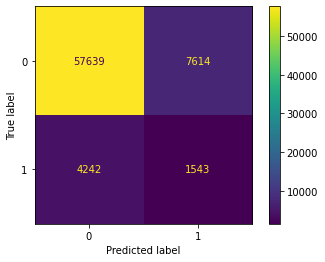

In [508]:
if models['model_1']:
    model_1 = BernoulliNB()
    model_1.fit(X_train, y_train)
    y_pred = model_1.predict(X_test)
    y_pred_proba = model_1.predict_proba(X_test)[:, 1]
    print(f'acc: {accuracy_score(y_test, y_pred)}, auc: {roc_auc_score(y_test, y_pred_proba)}')
#     cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
#     ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
#     cmd.plot()
    plt.show()
    results = results.append({'model': 'model_1',
                              'library': 'sklearn',
                              'algorithms': 'BernoulliNB',
                              'hyperparameters': 'None',
                              'score': {'acc': accuracy_score(y_test, y_pred), 'auc': roc_auc_score(y_test, y_pred_proba)}},
                             ignore_index=True)

## Random forest

In [509]:
models['model_2']

1

In [516]:
if models['model_2']:
    rfc = RandomForestClassifier(random_state=21)
    param_grid = { 
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [10, 2, 4, 8, 16],
        'criterion': ['gini','entropy'],
        'class_weight': ['balanced']
    }
    gs_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
#     gs_rfc = GridSearchCV(estimator=rfc,param_grid={'class_weight': ['balanced']}, cv=5, verbose=1, n_jobs=-1)
    print("a")
    gs_rfc.fit(X_train, y_train)
    print("b")
    print(gs_rfc.best_params_)
    model_2 = RandomForestClassifier(random_state=21,
                                     n_estimators=gs_rfc.best_params_['n_estimators'], # 200
                                     max_features=gs_rfc.best_params_['max_features'], # 'auto'
                                     max_depth=gs_rfc.best_params_['max_depth'], # 10
                                     criterion=gs_rfc.best_params_['criterion'], # 'gini'
                                     class_weight=gs_rfc.best_params_['class_weight']) # None
    model_2.fit(X_train, y_train)
    y_pred = model_2.predict(X_test)
    y_pred_proba = model_2.predict_proba(X_test)[:, 1]
    print(f'acc: {accuracy_score(y_test, y_pred)}, auc: {roc_auc_score(y_test, y_pred_proba)}')
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()    
#     ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    hyperparameters = {
        'n_estimators': gs_rfc.best_params_['n_estimators'],
        'max_features': gs_rfc.best_params_['max_features'],
        'max_depth': gs_rfc.best_params_['max_depth'],
        'criterion': gs_rfc.best_params_['criterion'],
        'class_weight': gs_rfc.best_params_['class_weight']
    }
    results = results.append({'model': 'model_2',
                              'library': 'sklearn',
                              'algorithms': 'RandomForestClassifier',
                              'hyperparameters': hyperparameters,
                              'score': {'acc': accuracy_score(y_test, y_pred), 'auc': roc_auc_score(y_test, y_pred_proba)}},
                             ignore_index=True)

a
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.0s finished


ValueError: too many values to unpack (expected 4)

## MLPClassifier

In [517]:
if models['model_3']:
    mlpc = MLPClassifier(random_state=21)
    param_grid = {
        'solver': ['adam'],#, 'lbfgs'],
        'max_iter': [200],#, 300],
        'activation': ['relu'],#, 'logistic']
        'hidden_layer_sizes': [(64, 32, 1)],#, (100,)]
    }
    gs_mlpc = GridSearchCV(estimator=mlpc, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
    gs_mlpc.fit(X_train, y_train)
    print(gs_mlpc.best_params_)
    model_3 = MLPClassifier(random_state=21,
                            solver=gs_mlpc.best_params_['solver'],
                            max_iter=gs_mlpc.best_params_['max_iter'],
                            activation=gs_mlpc.best_params_['activation'],
                            hidden_layer_sizes=gs_mlpc.best_params_['hidden_layer_sizes'])
    model_3.fit(X_train, y_train)
    y_pred = model_3.predict(X_test)
    y_pred_proba = model_3.predict_proba(X_test)[:, 1]
    print(f'acc: {accuracy_score(y_test, y_pred)}, auc: {roc_auc_score(y_test, y_pred_proba)}')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    hyperparameters = {
        'solver': gs_mlpc.best_params_['solver'],
        'max_iter': gs_mlpc.best_params_['max_iter'],
        'activation': gs_mlpc.best_params_['activation'],
        'hidden_layer_sizes': gs_mlpc.best_params_['hidden_layer_sizes']
    }
    results = results.append({'model': 'model_3',
                              'library': 'sklearn',
                              'algorithms': 'MLPClassifier',
                              'hyperparameters': hyperparameters,
                              'score': {'acc': accuracy_score(y_test, y_pred), 'auc': roc_auc_score(y_test, y_pred_proba)}},
                             ignore_index=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.8min finished


ValueError: too many values to unpack (expected 4)

## Keras

In [116]:
if models['model_4']:
    model_4 = tf.keras.Sequential([layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
                                   layers.Dropout(0.5),
                                   layers.Dense(256, activation='relu'),
                                   layers.Dropout(0.5),
                                   layers.Dense(1, activation='sigmoid')])
    model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=tf.keras.metrics.AUC())
    history = model_4.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1)
    y_pred_proba = model_4.predict(X_test)
    y_pred = [int(label >= 0.5) for label in y_pred]
    print(f'acc: {accuracy_score(y_test, y_pred)}, auc: {roc_auc_score(y_test, y_pred_proba)}')
    

TypeError: Type of `metrics` argument not understood. Expected a list or dictionary, found: AUC(name=auc_1,dtype=float32,num_thresholds=200,curve=ROC,summation_method=interpolation,multi_label=False,label_weights=None)

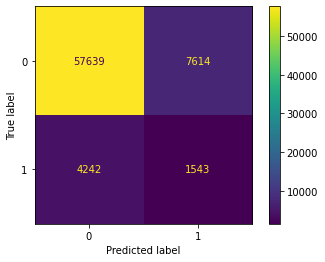

In [43]:
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()   
    plt.show()
    results = results.append({'model': 'model_4',
                              'library': 'tensorflow',
                              'algorithms': 'keras',
                              'hyperparameters': {'optimizer': 'Adam', 'loss': 'BinaryCrossentropy', 'metrics': 'AUC'},
                              'score': {'acc': accuracy_score(y_test, y_pred), 'auc': roc_auc_score(y_test, y_pred_proba)}},
                             ignore_index=True)

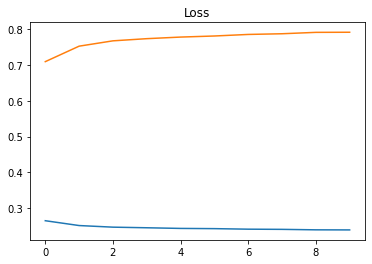

In [44]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['auc'], label='test')
plt.show()

## TensorFlow

In [ ]:
if models['model_5']:
    def input_fn(X, y): 
        dataset = tf.data.Dataset.from_tensor_slices((X, y))
        dataset = dataset.shuffle(1000).batch(1000)
        return dataset


    from tensorflow.estimator import BaselineClassifier
    clss = BaselineClassifier(n_classes=2)


    clss.train(input_fn=lambda: input_fn(X_train, y_train), max_steps=10)
    y_pred = clss.predict(input_fn=lambda: input_fn(X_test, y_test))

    y_pred = np.array([p['class_ids'][0] for p in y_pred])


In [111]:
if models['model_5']:
    # tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    # Определение входного тензора в граф
    inputs = tf.compat.v1.placeholder(dtype=tf.float32, shape=X_train.shape)
    

In [131]:
print(tf.__version__)
inputs[0]

2.7.0


<tf.Tensor 'strided_slice_16:0' shape=(102,) dtype=float32>

In [121]:
if models['model_5']:
# Определение графа вычислений
    x = tf.compat.v1.layers.dense(inputs, 64, activation='relu')#, input_shape=(X_train.shape[1],))
    # x = tf.compat.v1.layers.batch_normalization(x)
    output_tensor = tf.compat.v1.nn.sigmoid(x)
    # Использование tf.Session() для вычислений
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        outputs = sess.run([output_tensor],  feed_dict={inputs: np.random.randint(0, 256, (1, 224, 224, 3)).astype(np.float32)})

<ipython-input-121-e2061e0de4d4>:3: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.compat.v1.layers.dense(inputs, 64, activation='relu')#, input_shape=(X_train.shape[1],))
/Users/papa/Desktop/21school/python_DS/day03/ex00/rgero/lib/python3.8/site-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


ValueError: Cannot feed value of shape (1, 224, 224, 3) for Tensor Placeholder_7:0, which has shape (284152, 102)

In [107]:
X_train

array([[-3.59331335e-01, -2.44462089e-01, -2.55477208e-01, ...,
        -2.81088628e-01, -2.81088628e-01, -2.81088628e-01],
       [-1.40781563e-01, -2.44462089e-01,  1.07670508e+00, ...,
         6.85501801e-04,  6.85501801e-04,  6.85501801e-04],
       [ 1.46883528e+00, -2.44462089e-01, -4.29432152e-01, ...,
         6.85501801e-04,  6.85501801e-04,  6.85501801e-04],
       ...,
       [-8.50918118e-01, -2.44462089e-01, -4.29432152e-01, ...,
         6.85501801e-04,  6.85501801e-04,  6.85501801e-04],
       [-2.81973970e-01, -2.44462089e-01,  5.31384559e-01, ...,
         6.85501801e-04,  6.85501801e-04,  6.85501801e-04],
       [-4.61767031e-01, -2.44462089e-01, -2.01142479e-01, ...,
         6.85501801e-04,  6.85501801e-04,  6.85501801e-04]])

# New tensorflow

In [643]:
import tensorflow.compat.v1 as tf_1 # use Tensorflow v1   

Epoch: 0000 cost=1.775619476
Epoch: 0010 cost=0.235443935
Epoch: 0020 cost=0.228659869
Epoch: 0030 cost=0.225291837
Epoch: 0040 cost=0.222836952
Optimization Finished!
acc: 0.918564711844365 , auc: 0.8071000196151616


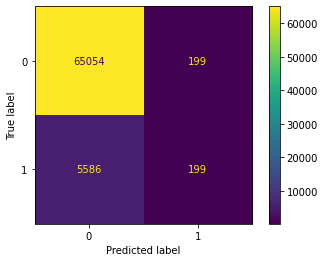

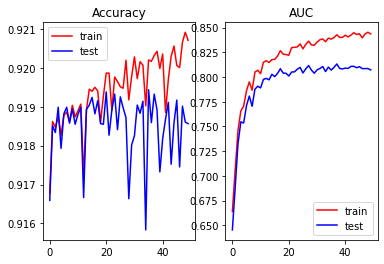

In [670]:
if models['model_5']: 
    tf_1.disable_v2_behavior() # use Tensorflow v1
    
    training_epochs = 50
    display_step = 10
    batch_size = 128
    learning_rate = 0.01

    n_hidden_1 = 64 # 1st layer number of neurons
    n_hidden_2 = 64 # 2nd layer number of neurons
    n_input = X_train.shape[1] 
    n_classes = 1
    # tf Graph input
    X = tf_1.placeholder('float32', [None, n_input])
    Y = tf_1.placeholder('float32', [None,  n_classes])
    weights = {
        'h1': tf_1.Variable(tf.random.normal([n_input, n_hidden_1])),
        'h2': tf_1.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
        'out': tf_1.Variable(tf.random.normal([n_hidden_2, n_classes]))
    }
    biases = {
        'b1': tf_1.Variable(tf.random.normal([n_hidden_1])),
        'b2': tf_1.Variable(tf.random.normal([n_hidden_2])),
        'out': tf_1.Variable(tf.random.normal([n_classes]))
    }
    
    def multilayer_perceptron(x):
        layer_1 = tf_1.nn.relu( tf_1.add(tf_1.matmul(x, weights['h1']), biases['b1']))
        layer_2 = tf_1.nn.relu( tf_1.add(tf_1.matmul(layer_1, weights['h2']), biases['b2']))
        out_layer = tf_1.matmul(layer_2, weights['out']) + biases['out']
        return out_layer

    def create_mini_batches(X, y, batch_size):
        y = np.reshape(y, (y.shape[0],1))
        mini_batches = []
        data = np.hstack((X, y))
        np.random.shuffle(data)
        n_minibatches = data.shape[0] // batch_size
        i = 0

        for i in range(n_minibatches + 1):
            mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
            X_mini = mini_batch[:, :-1]
            Y_mini = mini_batch[:, -1].reshape((-1, 1))
            mini_batches.append((X_mini, Y_mini))
        if data.shape[0] % batch_size != 0:
            mini_batch = data[i * batch_size:data.shape[0]]
            X_mini = mini_batch[:, :-1]
            Y_mini = mini_batch[:, -1].reshape((-1, 1))
            mini_batches.append((X_mini, Y_mini))
        return mini_batches
    
    # Construct model
    logits = multilayer_perceptron(X)
    # Define loss and optimizer
    loss_op = tf_1.reduce_mean(tf_1.nn.sigmoid_cross_entropy_with_logits(
        logits=logits, labels=Y))

    optimizer = tf_1.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, var_list=None) #[weights['out'], biases['out']])
    # Initializing the variables
    init = tf_1.global_variables_initializer()
    
    with tf_1.Session() as sess:
    #     v1.reset_default_graph()
        sess.run(init)
        # Training cycle
        for epoch in range(training_epochs):
            avg_cost = 0.
            mini_batches = create_mini_batches(X_train, y_train, batch_size)
            for mini_batch in mini_batches:
                X_mini, y_mini = mini_batch
                _, c = sess.run([train_op, loss_op], feed_dict={X: X_mini, Y: y_mini})
                # Compute average loss
                avg_cost += c / len(mini_batches)
            prediction = tf_1.nn.sigmoid(logits)
            y_pred_proba = sess.run(prediction, feed_dict={X: X_train})
            y_pred = [int(label >= 0.5) for label in y_pred_proba]
            acc_train = accuracy_score(y_train, y_pred)
            auc_train = roc_auc_score(y_train, y_pred_proba)
            y_pred_proba = sess.run(prediction, feed_dict={X: X_test})
            y_pred = [int(label >= 0.5) for label in y_pred_proba]
            acc_test = accuracy_score(y_test, y_pred)
            auc_test = roc_auc_score(y_test, y_pred_proba)
            newrow = [epoch, acc_train, acc_test, auc_train, auc_test]
            if epoch == 0:
                metrics = newrow
            else:
                metrics = np.vstack([metrics, newrow])
            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch), "cost={:.9f}".format(avg_cost))
        print("Optimization Finished!")

        # Evaluate model
        prediction = tf_1.nn.sigmoid(logits)
        y_pred_proba = sess.run(prediction, feed_dict={X: X_test})
        y_pred = [int(label >= 0.5) for label in y_pred_proba]
        print(f'acc: {accuracy_score(y_test, y_pred)} , auc: {roc_auc_score(y_test, y_pred_proba)}')
        ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()    
        plt.show()   
    
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title('Accuracy')
    plt.plot(metrics[:, 0], metrics[:, 1], c = 'red')
    plt.plot(metrics[:, 0], metrics[:, 2], c = 'blue')
    plt.legend(['train', 'test'])
    plt.subplot(1, 2, 2)
    plt.title('AUC')
    plt.plot(metrics[:, 0], metrics[:, 3], c = 'red')
    plt.plot(metrics[:, 0], metrics[:, 4], c = 'blue')
    plt.legend(['train', 'test'])
    plt.show()

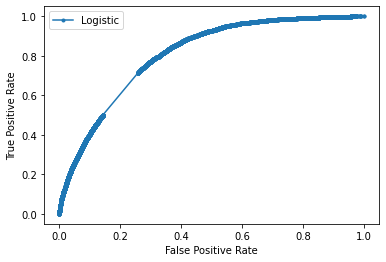

In [669]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred_proba)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [302]:
""" Neural Network.
A 2-Hidden Layers Fully Connected Neural Network (a.k.a Multilayer Perceptron)
implementation with TensorFlow. This example is using the MNIST database
of handwritten digits (http://yann.lecun.com/exdb/mnist/).
Links:
    [MNIST Dataset](http://yann.lecun.com/exdb/mnist/).
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
"""

# from __future__ import print_function

# # Import MNIST data
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# import tensorflow as tf

# Parameters
learning_rate = 0.1
num_steps = 500
batch_size = 128
display_step = 100

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}


# Create model
def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Construct model
logits = neural_net(X)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, num_steps+1):
#         batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sh = list(range(X_train.shape[0]))
        np.random.shuffle(sh)
        # batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        batch_x = X_train[0:batch_size]
        batch_y = np.reshape(y_train, (284152,1))[0:batch_size]
        
       
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for MNIST test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: X_test,
                                      Y: y_test}))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/dq/qcp6_hyx3sjbry3v45ns848r0000gq/T/tmpogxahagh', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


AttributeError: module 'tensorflow_estimator.python.estimator.api._v2.estimator' has no attribute 'inputs'

## Numpy

In [92]:
if models['model_6']:
    loss = CrossEntropy()
    net = ChurnNetMiniBatch()
    learning_rate = 0.001
    L_train = []
    L_test = []
    Acc_train = []
    Acc_test = []
    len_mini_batch = 10
    for it in range(10):
        L_acc = 0.
        sh = list(range(X_train.shape[0]))
        np.random.shuffle(sh)
        for i in range(X_train.shape[0]):
            x = X_train[sh[i]]
            y = y_train[sh[i]]
            y_h = net.forward(x)
            L = loss.forward(y, y_h)
            L_acc += L
            dz = loss.backward()
            if i % len_mini_batch == 0:
                dz = net.backward(
                    dz,
                    learning_rate,
                    update=True,
                    len_mini_batch=len_mini_batch)
            else:
                dz = net.backward(dz, learning_rate)
        L_acc /= y_train.shape[0]
        L_train.append(L_acc)
        acc = compute_acc(X_train, y_train, net)
        Acc_train.append(acc)
        L_e_acc = 0.
        for i in range(X_test.shape[0]):
            x = X_test[i]
            y = y_test[i]
            y_h = net.forward(x)
            L = loss.forward(y, y_h)
            L_e_acc += L
        L_e_acc /= y_test.shape[0]
        L_test.append(L_e_acc)
        acc = compute_acc(X_test, y_test, net)
        Acc_test.append(acc)

        learning_rate = learning_rate * 0.99

        print(
            "{} epoch. Train : {} . Test : {}. acc : {} . val_acc: {}".format(
                it + 1, L_acc, L_e_acc, Acc_train[-1], Acc_test[-1]))

1 epoch. Train : 0.27873590843878543 . Test : 0.5333981023432581. acc : 0.918564711844365 . val_acc: 0.918564711844365


<ipython-input-4-901154152a1a>:35: RuntimeWarning: overflow encountered in exp
  s = 1/(1 + np.exp(-dz))


2 epoch. Train : 0.7952028664713039 . Test : 1.0593535491534356. acc : 0.918564711844365 . val_acc: 0.918564711844365
3 epoch. Train : 1.3213158375066807 . Test : 1.5801674799365957. acc : 0.918564711844365 . val_acc: 0.918564711844365
4 epoch. Train : 1.836681050580683 . Test : 2.095772343834818. acc : 0.918564711844365 . val_acc: 0.918564711844365
5 epoch. Train : 2.349690663433418 . Test : 2.6062259849379164. acc : 0.918564711844365 . val_acc: 0.918564711844365
6 epoch. Train : 2.8586841220221335 . Test : 3.1115693046472352. acc : 0.918564711844365 . val_acc: 0.918564711844365
7 epoch. Train : 3.3625641370279835 . Test : 3.611862381348816. acc : 0.918564711844365 . val_acc: 0.918564711844365
8 epoch. Train : 3.8583562091798487 . Test : 4.1071522323015515. acc : 0.918564711844365 . val_acc: 0.918564711844365
9 epoch. Train : 4.351724130066014 . Test : 4.597491124151883. acc : 0.918564711844365 . val_acc: 0.918564711844365
10 epoch. Train : 4.839109358051584 . Test : 5.082922907456152

In [95]:
Acc_train

[0.918564711844365,
 0.918564711844365,
 0.918564711844365,
 0.918564711844365,
 0.918564711844365,
 0.918564711844365,
 0.918564711844365,
 0.918564711844365,
 0.918564711844365,
 0.918564711844365]

# Results

In [93]:
results

,model,library,algorithms,hyperparameters,score
